In [ ]:
!curl -sSf https://sshx.io/get | sh -s run

↯ Downloading sshx from https://s3.amazonaws.com/sshx/sshx-x86_64-unknown-linux-musl.tar.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2904k  100 2904k    0     0  1425k      0  0:00:02  0:00:02 --:--:-- 1425k

↯ Adding sshx binary to /tmp/tmp.wraE2EsAEg
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'

↯ Done! You can now run sshx.

  sshx v0.4.1

  ➜  Link:  https://sshx.io/s/Ri0wodGedI#PruIyuYpxAg3Gh
  ➜  Shell: /bin/bash



In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from google.colab import files

In [ ]:
# Install Kaggle library
!pip install -q kaggle
!mkdir -p ~/.kaggle
# Upload Kaggle API key file (might have to rerun to work)
files.upload()

# Download the dataset
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip it
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

In [ ]:
# Set data directory
data_dir = "/content"

# Load metadata
df_meta = pd.read_csv(os.path.join(data_dir, "HAM10000_metadata.csv"))

# Select only the required classes: 'df', 'vasc', 'akiec'
selected_classes = ['df', 'vasc', 'akiec']
df_meta = df_meta[df_meta['dx'].isin(selected_classes)].reset_index(drop=True)

# Collect all image paths from both directories
image_paths = glob('/content/HAM10000_images_part_1/*.jpg') + glob('/content/HAM10000_images_part_2/*.jpg')

# Create a dictionary mapping image IDs to their full paths
imageid_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in image_paths
}

# Map image paths to the metadata dataframe
df_meta['path'] = df_meta['image_id'].map(imageid_path_dict.get)

# Check for missing paths
if df_meta['path'].isnull().any():
    print("Some images are missing from the provided directories!")
    missing_ids = df_meta[df_meta['path'].isnull()]['image_id'].tolist()
    print(f"Missing image IDs: {missing_ids}")

# Map categorical labels to numeric values
label_mapping = {label: idx for idx, label in enumerate(selected_classes)}
df_meta['label'] = df_meta['dx'].map(label_mapping)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df_meta, stratify=df_meta['label'], test_size=0.2, random_state=42)


In [ ]:
# Augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images
augmented_dir = os.path.join(data_dir, "augmented_images")
os.makedirs(augmented_dir, exist_ok=True)

def augment_and_save_images(df, imgs_to_generate=500):
    augmented_data = []

    for class_label in df['label'].unique():
        class_data = df[df['label'] == class_label]
        img_count = len(class_data)

        for i in range(imgs_to_generate):
            img_path = class_data.iloc[i % img_count]['path']
            img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.utils.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            augmented_images = datagen.flow(img_array, batch_size=1)
            for aug_img in augmented_images:
                save_path = os.path.join(augmented_dir, f"{class_label}_{i}.jpg")
                tf.keras.preprocessing.image.save_img(save_path, aug_img[0])
                augmented_data.append((save_path, class_label))
                break

    return pd.DataFrame(augmented_data, columns=['path', 'label'])


In [ ]:
# Augment training data
augmented_train_df = augment_and_save_images(train_df)

# Combine augmented data with original training data
train_df_combined = pd.concat([train_df[['path', 'label']], augmented_train_df], ignore_index=True)

# Convert 'label' column to string
train_df_combined['label'] = train_df_combined['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

In [ ]:
# Prepare data generators for training and validation
train_gen = datagen.flow_from_dataframe(
    train_df_combined,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

val_gen = ImageDataGenerator().flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)


Found 1967 validated image filenames belonging to 3 classes.
Found 117 validated image filenames belonging to 3 classes.


In [ ]:
def squeeze_excite_block(input, ratio=8):
    filters = input.shape[-1]
    se = GlobalAveragePooling2D()(input)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input, se])

In [ ]:
# Model architecture with InceptionV3 + Attention Mechanism
base_model = InceptionV3(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = squeeze_excite_block(x)  # Apply Attention mechanism (SE Block)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(selected_classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Load the checkpoint model if it exists
checkpoint_to_load = "/content/manual_model_epoch_75.h5"
if os.path.exists(checkpoint_to_load):
    print(f"Loading model from {checkpoint_to_load}")
    model = load_model(checkpoint_to_load)
else:
    print("Checkpoint not found. Proceeding with untrained model.")

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint and learning rate reduction callbacks
checkpoint_dir = os.path.join(data_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.h5"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Load the previous history if it exists
history_dir = os.path.join(data_dir, "history_files")
os.makedirs(history_dir, exist_ok=True)

history_file = os.path.join(history_dir, 'train_history.pkl')

# Load the history file from the specified path
history_to_load = "/content/train_history_epoch_75.pkl"
if os.path.exists(history_to_load):
    print(f"Loading training history from {history_to_load}")
    with open(history_to_load, 'rb') as f:
        saved_history = pickle.load(f)
else:
    print("Training history not found. Proceeding with empty history.")
    saved_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

# Save the history
def save_history(history, epoch):
    session_history_file = os.path.join(history_dir, f'train_history_epoch_{epoch}.pkl')
    with open(session_history_file, 'wb') as f:
        pickle.dump(history, f)
    print(f"History saved at: {session_history_file}")

# Define training parameters
initial_epoch = len(saved_history['accuracy'])  # Continue from the last saved epoch
print(f"Initial epoch set to: {initial_epoch}")

total_epochs = 100
epochs_per_session = 15

# Train in increments of epochs
while initial_epoch < total_epochs:
    print(f"Starting training from epoch {initial_epoch} to {initial_epoch + epochs_per_session}")

    # Train the model for the current session
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=initial_epoch + epochs_per_session,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )

    # Load previous history and save only available keys
    for key in history.history:
        if key in saved_history:
            saved_history[key].extend(history.history[key])
        else:
            saved_history[key] = history.history[key]

    save_history(saved_history, initial_epoch + epochs_per_session)

    # Save the model manually after every session
    model_save_path = os.path.join(checkpoint_dir, f"manual_model_epoch_{initial_epoch + epochs_per_session}.h5")
    model.save(model_save_path)
    print(f"Model manually saved at: {model_save_path}")

    # Update initial epoch for the next session
    initial_epoch += epochs_per_session

    print(f"Completed {initial_epoch} epochs. You can now switch to another session and resume training.")

val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")




Checkpoint not found. Proceeding with untrained model.
Training history not found. Proceeding with empty history.
Initial epoch set to: 0
Starting training from epoch 0 to 15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.4279 - loss: 13.8129
Epoch 1: val_loss improved from inf to 0.91621, saving model to /content/checkpoints/model_epoch_001_val_loss_0.9162.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 904ms/step - accuracy: 0.4286 - loss: 13.6961 - val_accuracy: 0.6752 - val_loss: 0.9162 - learning_rate: 0.0010
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5215 - loss: 0.9768
Epoch 2: val_loss did not improve from 0.91621
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.5214 - loss: 0.9768 - val_accuracy: 0.6410 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.5461 - loss: 0.9341
Epoch 3: val_loss improved from 0.91621 to 0.83421, saving model to /content/checkpoints/model_epoch_003_val_loss_0.8342.h5


62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 525ms/step - accuracy: 0.5462 - loss: 0.9340 - val_accuracy: 0.7094 - val_loss: 0.8342 - learning_rate: 0.0010
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5293 - loss: 0.9721
Epoch 4: val_loss did not improve from 0.83421
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 486ms/step - accuracy: 0.5294 - loss: 0.9716 - val_accuracy: 0.6496 - val_loss: 0.8465 - learning_rate: 0.0010
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.5248 - loss: 0.9228
Epoch 5: val_loss did not improve from 0.83421
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - accuracy: 0.5249 - loss: 0.9229 - val_accuracy: 0.6667 - val_loss: 0.8835 - learning_rate: 0.0010
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.5340 - loss: 0.9150
Epoch 6: val_loss did not improve from 0.83421
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 507ms/step - accuracy: 0.5339 - loss: 0.9151 - val_accuracy: 0.5385 - val_loss: 0.9013 - learning_rate: 0.0010
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 506ms/step - accuracy: 0.5225 - loss: 0.8990 - val_accuracy: 0.7009 - val_loss: 0.8339 - learning_rate: 2.0000e-04
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.5378 - loss: 0.8849
Epoch 8: val_loss did not improve from 0.83390
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 516ms/step - accuracy: 0.5377 - loss: 0.8849 - val_accuracy: 0.7094 - val_loss: 0.8417 - learning_rate: 2.0000e-04
Epoch 9/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.5732 - loss: 0.8847
Epoch 9: val_loss did not improve from 0.83390
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 479ms/step - accuracy: 0.5732 - loss: 0.8848 - val_accuracy: 0.6667 - val_loss: 0.8368 - learning_rate: 2.0000e-04
Epoch 10/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.5833 - loss: 0.8635
Epoch 10: val_loss did not improve from 0.83390
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - accuracy: 0.5831 - loss: 0.8637 - val_accuracy: 0.6667 - val_loss: 0.8397 - learning_rate: 2.0000e-04
Epoch 11/15
62/

62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.5569 - loss: 0.8930 - val_accuracy: 0.7179 - val_loss: 0.8082 - learning_rate: 4.0000e-05
Epoch 12/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5786 - loss: 0.8219
Epoch 12: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 528ms/step - accuracy: 0.5783 - loss: 0.8225 - val_accuracy: 0.7094 - val_loss: 0.8180 - learning_rate: 4.0000e-05
Epoch 13/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.5747 - loss: 0.8868
Epoch 13: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 488ms/step - accuracy: 0.5747 - loss: 0.8868 - val_accuracy: 0.6838 - val_loss: 0.8252 - learning_rate: 4.0000e-05
Epoch 14/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5700 - loss: 0.8686
Epoch 14: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 481ms/step - accuracy: 0.5701 - loss: 0.8685 - val_accuracy: 0.7009 - val_loss: 0.8095 - learning_rate: 4.0000e-05
Epoch 15/15

History saved at: /content/history_files/train_history_epoch_15.pkl
Model manually saved at: /content/checkpoints/manual_model_epoch_15.h5
Completed 15 epochs. You can now switch to another session and resume training.
Starting training from epoch 15 to 30
Epoch 16/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5605 - loss: 0.8936
Epoch 16: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.5607 - loss: 0.8933 - val_accuracy: 0.7009 - val_loss: 0.8156 - learning_rate: 8.0000e-06
Epoch 17/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.5892 - loss: 0.8539
Epoch 17: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.5890 - loss: 0.8542 - val_accuracy: 0.7094 - val_loss: 0.8137 - learning_rate: 8.0000e-06
Epoch 18/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.5742 - loss: 0.8607
Epoch 18: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 477ms/step - ac

History saved at: /content/history_files/train_history_epoch_30.pkl
Model manually saved at: /content/checkpoints/manual_model_epoch_30.h5
Completed 30 epochs. You can now switch to another session and resume training.
Starting training from epoch 30 to 45
Epoch 31/45
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5704 - loss: 0.8782
Epoch 31: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 520ms/step - accuracy: 0.5704 - loss: 0.8781 - val_accuracy: 0.7094 - val_loss: 0.8138 - learning_rate: 1.0000e-06
Epoch 32/45
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5794 - loss: 0.8739
Epoch 32: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 507ms/step - accuracy: 0.5793 - loss: 0.8740 - val_accuracy: 0.7094 - val_loss: 0.8140 - learning_rate: 1.0000e-06
Epoch 33/45
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5585 - loss: 0.8775
Epoch 33: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 487ms/step - ac

History saved at: /content/history_files/train_history_epoch_45.pkl
Model manually saved at: /content/checkpoints/manual_model_epoch_45.h5
Completed 45 epochs. You can now switch to another session and resume training.
Starting training from epoch 45 to 60
Epoch 46/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5893 - loss: 0.8629
Epoch 46: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 504ms/step - accuracy: 0.5894 - loss: 0.8628 - val_accuracy: 0.7094 - val_loss: 0.8137 - learning_rate: 1.0000e-06
Epoch 47/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.5661 - loss: 0.8670
Epoch 47: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 518ms/step - accuracy: 0.5662 - loss: 0.8670 - val_accuracy: 0.7094 - val_loss: 0.8135 - learning_rate: 1.0000e-06
Epoch 48/60
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5678 - loss: 0.8821
Epoch 48: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 511ms/step - ac

History saved at: /content/history_files/train_history_epoch_60.pkl
Model manually saved at: /content/checkpoints/manual_model_epoch_60.h5
Completed 60 epochs. You can now switch to another session and resume training.
Starting training from epoch 60 to 75
Epoch 61/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5869 - loss: 0.8692
Epoch 61: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 501ms/step - accuracy: 0.5866 - loss: 0.8692 - val_accuracy: 0.7094 - val_loss: 0.8131 - learning_rate: 1.0000e-06
Epoch 62/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.5849 - loss: 0.8671
Epoch 62: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 538ms/step - accuracy: 0.5847 - loss: 0.8671 - val_accuracy: 0.7094 - val_loss: 0.8128 - learning_rate: 1.0000e-06
Epoch 63/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.5395 - loss: 0.8905
Epoch 63: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 494ms/step - ac

History saved at: /content/history_files/train_history_epoch_75.pkl
Model manually saved at: /content/checkpoints/manual_model_epoch_75.h5
Completed 75 epochs. You can now switch to another session and resume training.
Starting training from epoch 75 to 90
Epoch 76/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.5738 - loss: 0.8742
Epoch 76: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 532ms/step - accuracy: 0.5738 - loss: 0.8740 - val_accuracy: 0.7179 - val_loss: 0.8119 - learning_rate: 1.0000e-06
Epoch 77/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.5812 - loss: 0.8634
Epoch 77: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 490ms/step - accuracy: 0.5811 - loss: 0.8635 - val_accuracy: 0.7179 - val_loss: 0.8120 - learning_rate: 1.0000e-06
Epoch 78/90
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.5898 - loss: 0.8556
Epoch 78: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 509ms/step - ac

History saved at: /content/history_files/train_history_epoch_90.pkl
Model manually saved at: /content/checkpoints/manual_model_epoch_90.h5
Completed 90 epochs. You can now switch to another session and resume training.
Starting training from epoch 90 to 105
Epoch 91/105
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.5785 - loss: 0.8594
Epoch 91: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.5787 - loss: 0.8593 - val_accuracy: 0.7179 - val_loss: 0.8116 - learning_rate: 1.0000e-06
Epoch 92/105
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.5780 - loss: 0.8508
Epoch 92: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 487ms/step - accuracy: 0.5780 - loss: 0.8509 - val_accuracy: 0.7179 - val_loss: 0.8118 - learning_rate: 1.0000e-06
Epoch 93/105
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.5578 - loss: 0.8912
Epoch 93: val_loss did not improve from 0.80819
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 522ms/step 

History saved at: /content/history_files/train_history_epoch_105.pkl
Model manually saved at: /content/checkpoints/manual_model_epoch_105.h5
Completed 105 epochs. You can now switch to another session and resume training.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.7497 - loss: 0.7976
Validation Loss: 0.8116, Validation Accuracy: 0.7179


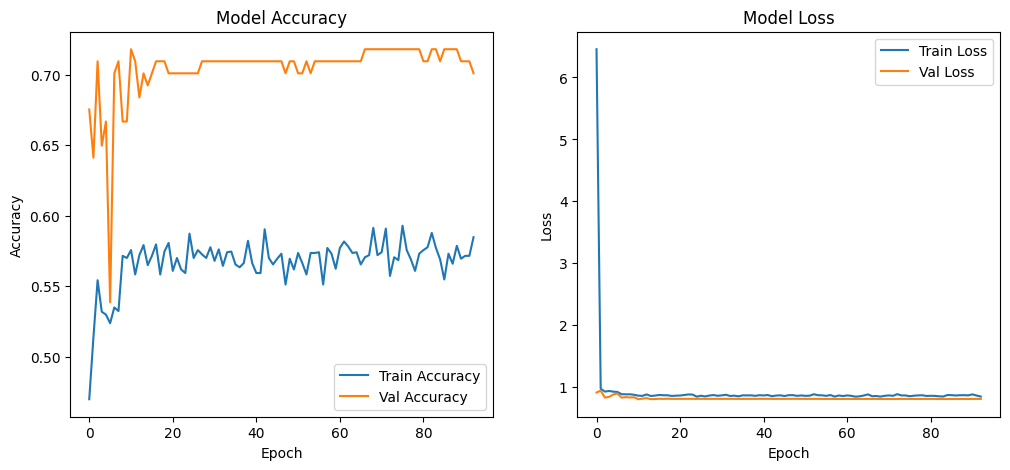

In [ ]:
with open(history_file, 'rb') as f:
    final_history = pickle.load(f)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['accuracy'], label='Train Accuracy')
plt.plot(final_history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['loss'], label='Train Loss')
plt.plot(final_history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()